In [1]:
# Load Dataset

import torch
torch.set_default_dtype(torch.float32)
dataset = torch.load("../torchfem_dataset/simple_beam_reduced/combined_50.pt",weights_only=False)
#dataset_2 = torch.load("../torchfem_dataset/tube_2/tube_combined.pt",weights_only=False)

In [2]:
## Process dataset for training - Nodes only
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import coalesce
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData

def build_laststep_features(data,dtype=torch.float32):
    ## Collapse to peak load timestep
    #print(data.keys)
    len = data['nodes'].f_ext.shape[0]
    t = int(len-1)
    # Nodes: x = [pos, bc, f_ext[-1], f_int[-1]]  (no leakage of u_ts into x)
    #pos   = data['nodes'].pos.to(dtype) #no need to include
    bc    = data['nodes'].bc
    f_ext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].fext = torch.Tensor(data['nodes'].f_ext[t]).to(dtype)
    data['nodes'].x = torch.cat([bc, f_ext], dim=-1).to(dtype)


    # Target: nodes â†’ u_ts[-1] (3D)
    data['nodes'].y_u = data['nodes'].u_ts[t].to(dtype)
    data['nodes'].y_fint = data['nodes'].f_ts[t].to(dtype)

    # (Optional) free large tensors you won't use further to save RAM/VRAM
    del data['nodes'].bc, data['nodes'].u_ts, data['nodes'].f_ext, data['nodes'].f_int, data['elements'].material#, data['nodes'].pos
    del data['elements'].s_ts, data['elements'].d_ts, data['elements'].material, data['nodes'].f_ts, data['elements'].s_ts, data['elements']
    del data[('nodes','belongs_to','elements')], data[('elements','contributes','nodes')]

    #print(data.keys)

    return data

class HeteroStandardScaler:
    def __init__(self):
        self.node_stats = {}
        self.edge_stats = {}

    def fit(self, dataset):
        node_x = torch.cat([d['nodes'].x[:,3:].float() for d in dataset],dim=0)
        node_f = torch.cat([d['nodes'].y_fint.float() for d in dataset],dim=0)
        node_u = torch.cat([d['nodes'].y_u.float() for d in dataset],dim=0)
        edge_acc = {}
        # compute mean/std
        for data in dataset:

            for etype in data.edge_types:
                if "edge_attr" in data[etype]:
                    edge_acc.setdefault(etype, []).append(data[etype].edge_attr.float())
        
        self.node_stats['nodes_x'] = {
            "mean": node_x.mean(dim=0, keepdim=True),
            "std":  node_x.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_f'] = {
            "mean": node_f.mean(dim=0, keepdim=True),
            "std":  node_f.std(dim=0, keepdim=True) + 1e-8}
        self.node_stats['nodes_u'] = {
            #"mean": node_u.mean(dim=0, keepdim=True),
            "mean": torch.zeros_like(node_u.mean(dim=0, keepdim=True)),
            "std":  node_u.std(dim=0, keepdim=True) + 1e-8}

        for etype, mats in edge_acc.items():
            E = torch.cat(mats, dim=0)
            self.edge_stats[etype] = {
                "mean": E.mean(dim=0, keepdim=True),
                "std":  E.std(dim=0, keepdim=True) + 1e-8}


    def transform(self, data: HeteroData):
        # apply normalization
        x = data['nodes'].x[:,3:].float()
        m_x = self.node_stats['nodes_x']["mean"]
        s_x = self.node_stats['nodes_x']["std"]
        data['nodes'].x[:,3:] = (x - m_x) / s_x

        y_f = data['nodes'].y_fint.float()
        m_f = self.node_stats['nodes_f']["mean"]
        s_f = self.node_stats['nodes_f']["std"]
        data['nodes'].y_fint = (y_f - m_f) / s_f
        
        y_u = data['nodes'].y_u.float()
        m_u = self.node_stats['nodes_u']["mean"]
        s_u = self.node_stats['nodes_u']["std"]
        data['nodes'].y_u = (y_u - m_u) / s_u

        # edges
        for etype in data.edge_types:
            if etype in self.edge_stats and "edge_attr" in data[etype]:
                e = data[etype].edge_attr.float()
                m = self.edge_stats[etype]["mean"]
                s = self.edge_stats[etype]["std"]
                data[etype].edge_attr = (e - m) / s

        return data
    
    def inverse_transform(self, data: HeteroData):
        # Nodes
        m, s = self.node_stats["nodes_u"]["mean"], self.node_stats["nodes_u"]["std"]
        data = data * s + m

        return data

def make_undirected(data):
    e = data['nodes','adjacent','nodes']
    ei = torch.cat([e.edge_index, e.edge_index.flip(0)], dim=1)
    ea = torch.cat([e.edge_attr,  e.edge_attr], dim=0)
    ei, ea = coalesce(ei, ea, num_nodes=data['nodes'].num_nodes, reduce='first')
    data['nodes','adjacent','nodes'].edge_index = ei
    data['nodes','adjacent','nodes'].edge_attr  = ea
    if ('nodes','adjacent_rev','nodes') in data.edge_types:
        del data['nodes','adjacent_rev','nodes']
    return data

scaler = HeteroStandardScaler()
## DataLoader with train/val split
dataset_p = [build_laststep_features(d) for d in dataset]
dataset_p = [make_undirected(d) for d in dataset_p]
scaler.fit(dataset_p)
dataset_t = [scaler.transform(d) for d in dataset_p]

def split_dataset(dataset, val_ratio=0.1, shuffle=True):
    n = len(dataset)
    idx = torch.randperm(n) if shuffle else torch.arange(n)
    n_val = max(1, int(n * val_ratio))
    val_idx = idx[:n_val].tolist()
    train_idx = idx[n_val:].tolist()
    train_set = [dataset[i] for i in train_idx]
    val_set   = [dataset[i] for i in val_idx]
    return train_set, val_set

# preprocess first
train_set, val_set = split_dataset(dataset_t, val_ratio=0.1)


0.22350716590881348


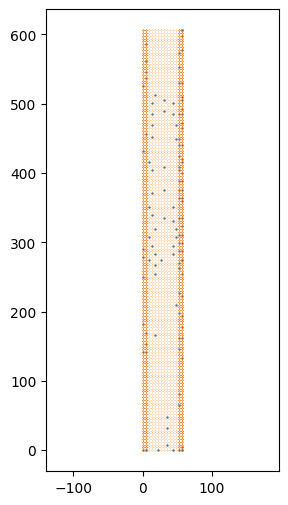

In [162]:
# Pooling
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, Delaunay
import time

train_set[0]['nodes']['pos']

def minmax_norm(t):
    # t: (906, 10, 3)
    t_min = t.amin(dim=(0, 1), keepdim=True)   # shape (1, 1, 3)
    t_max = t.amax(dim=(0, 1), keepdim=True)   # shape (1, 1, 3)
    return (t - t_min) / (t_max - t_min + 1e-8)

def coarsen(data):
    # sample points spatially
    pts = data['nodes']['pos']
    frac = 0.05
    N = pts.shape[0]
    M = max(1,int(np.round(frac*N)))
    rng = np.random.default_rng(42)
    selected_idx = np.empty(M,dtype=int)

    start = rng.integers(N)
    selected_idx[0] = start
    diff = pts - pts[start]
    min_dist2 = np.einsum("ij,ij->i", diff, diff)
    min_dist2[start] = 0.0

    for i in range(1, M):
        idx = np.argmax(min_dist2)
        selected_idx[i] = idx

        diff = pts - pts[idx]                      
        dist2 = np.einsum("ij,ij->i", diff, diff)   
        min_dist2 = np.minimum(min_dist2, dist2)   
        min_dist2[idx] = 0.0                      
    pts_filtered = pts[selected_idx]

    # select 5% of points at boundary condition edges & 5% of points with similar surroundings
    # BC edges => diff
    tree = cKDTree(pts)
    query_pts = tree.query(pts_filtered,k=11)
    query_pts = query_pts[1]
    query_self = query_pts[:,0]
    query_pts = query_pts[:,1:]
    features = data['nodes']['x'][query_pts]
    bc_norm = minmax_norm(features[:,:,:3])
    fext_norm = minmax_norm(features[:,:,3:])
    features = torch.cat([bc_norm,fext_norm],dim=-1)
    features_std = torch.std(features,dim=1)
    std_sum = torch.mean(features_std,dim=1) #standard deviations of BCs + forces (0-1 normalized)
    
    rel_pos = data['nodes']['pos'][query_pts]-(data['nodes']['pos'][query_self]).unsqueeze(1).repeat(1, 10, 1)
    rel_pos = minmax_norm(rel_pos)
    relpos_std = torch.std(rel_pos,dim=1)
    pos_std_sum = torch.mean(relpos_std,dim=1) #standard deviations of relative positions
    feature_norm = torch.stack([std_sum,pos_std_sum],dim=1) # geometry & fixity & external forces -> based on neighborhood
    feature_norm = torch.sum(feature_norm,axis=1)

    # similar surroundings => norm. distance
    pts_high_norm = pts_filtered[(feature_norm >= np.percentile(feature_norm,96)) | (feature_norm <= np.percentile(feature_norm,3))]
    pts_low_norm = pts_filtered[(feature_norm >= np.percentile(feature_norm,49)) & (feature_norm <= np.percentile(feature_norm,51))]
    pts_significant = torch.cat([pts_high_norm,pts_low_norm],dim=0)
    #TODO get original indices
    sig_mask = ((feature_norm >= np.percentile(feature_norm, 96)) |
                (feature_norm <= np.percentile(feature_norm, 3)))
    mid_mask = ((feature_norm >= np.percentile(feature_norm, 49)) &
                (feature_norm <= np.percentile(feature_norm, 51)))
    sig_idx_in_filtered = torch.where(sig_mask | mid_mask)[0]          # positions in pts_filtered
    sig_idx_original = torch.as_tensor(selected_idx)[sig_idx_in_filtered]  # indices into data['nodes']['pos']


    # fixed BC => fixed also after aggregation
    fixity_mask = ((data['nodes']['x'][sig_idx_original,:3]).sum(dim=1)==0)
    pts_free = pts_significant[fixity_mask]
    pts_fixed = pts_significant[~fixity_mask]

    # connect points via Delaunay tetrahedralization
    tri = Delaunay(pts_significant)
    tets = tri.simplices
    tet_edges = np.array([
    [0, 1],
    [0, 2],
    [0, 3],
    [1, 2],
    [1, 3],
    [2, 3]])
    edges = tets[:, tet_edges].reshape(-1, 2)
    edges_undirected = np.sort(edges, axis=1)
    edges_undirected = np.unique(edges_undirected, axis=0)
    i = edges_undirected[:, 0]
    j = edges_undirected[:, 1]
    edge_attr = pts_significant[j] - pts_significant[i]

    # aggregate information to filtered point ==> based on spatial + feature distance
    tree_f = cKDTree(pts_free)
    dists, idx_nearest = tree_f.query(pts,k=1)
    groups = [data['nodes']['x'][idx_nearest==j] for j in range(len(pts_free))]
    pooled = torch.stack([g.sum(dim=0) for g in groups])
    pooled[:,:3] = 0

    return pooled, pts_significant

# filter out close/similar points ==> similar to hospital point cloud TODO?

    


start = time.time()
query_pts, coarse_pts = coarsen(train_set[0])
end = time.time()
plt.figure(figsize=(3,6))
plt.scatter(coarse_pts[:,1],coarse_pts[:,2],s=0.5)
plt.scatter(train_set[0]['nodes']['pos'][:,1],train_set[0]['nodes']['pos'][:,2],s=0.01)
plt.axis('equal')
print(end-start)

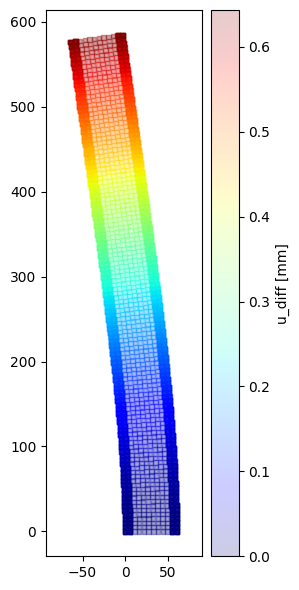

In [3]:
import matplotlib.pyplot as plt
import numpy as np
dataset_n = [scaler.inverse_transform(d['nodes']['y_u']) for d in dataset_t]
for i,out_sample in enumerate(dataset_t):

    fig = plt.figure(figsize=(3, 6))
    #plt.title(f'Sample {sample}',fontsize=10)

    #sc = ax.scatter(out_samples[sample]['nodes']['pos'],'k',alpha=0.3,label='initial position')
    #ax[i,1].plot(out_samples[sample]['nodes']['pred_u'][:],alpha=0.3,label='predicted')

    #ax.plot_trisurf(V[:,0],V[:,1],V[:,2],triangles=F,edgecolor='#888888',linewidth=lw,antialiased=True,color='#dddddd',alpha=0.1)

    vis_scale = 100

    pos_init = out_sample['nodes']['pos']
    pos_true = pos_init+dataset_n[i]*vis_scale
    pos_diff = np.linalg.norm(dataset_n[i],axis=-1)

    #force_true = out_sample['nodes']['f_ts'][ts]
    #force_diff = np.linalg.norm(force_true,axis=-1)

    #sc = ax.scatter(pos_init[:,0],pos_init[:,1],pos_init[:,2],s=2,marker='s',c='#1111dd',alpha=0.2,depthshade=True)
    #sc2 = ax.scatter(pos_true[:,0],pos_true[:,1],pos_true[:,2],s=2,marker='s',c='#11dd11',alpha=0.1,depthshade=True)
    #sc3 = ax.scatter(pos_pred[:,0],pos_pred[:,1],pos_pred[:,2],s=2,marker='s',c='#dd1111',alpha=0.2,depthshade=True)
    sc = plt.scatter(pos_true[:,1],pos_true[:,2],s=10,marker='s',c=pos_diff,cmap='jet',alpha=0.2)
    plt.colorbar(sc, label='u_diff [mm]')

    plt.axis('equal')

    plt.tight_layout()
    plt.show()
    break